$$
z_1 \sim N(µ_0; \Sigma_0)
$$
$$
z_t \sim N(G_{\alpha}(z_{t−1},u_{t−1}),S_{\beta}(z_{t−1},u_{t−1})) 
$$
$$
x_t ∼ Π(F_κ(z_t)).
$$

In [141]:
import numpy as np
import torch
from torch import Tensor
from torch import nn

In [2]:
import healing_mnist

hmnist = healing_mnist.HealingMNIST()

/home/vadim/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/vadim/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
def encode_rotations(rotations, dim=30):
    return np.stack([np.sin(np.deg2rad(rotations) * (i + 1)) for i in range(dim)], axis=2)

In [4]:
u_dim = 30
X_train = hmnist.train_images.reshape(hmnist.train_images.shape[0], hmnist.train_images.shape[1], 28 * 28)
u_train = encode_rotations(hmnist.train_rotations)

In [181]:
class LSTMTransition(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.cell1 = torch.nn.LSTMCell(u_dim, 50)
        self.cell2 = torch.nn.LSTMCell(50, 50)
        
    def forward(self, input, prev_state):
        h1 = prev_state[:,:50]
        c1 = prev_state[:,50:100]
        h2 = prev_state[:,100:150]
        c2 = prev_state[:,150:200]
        
        h1_next, c1_next = self.cell1(input, (h1, c1))
        h2_next, c2_next = self.cell2(h1_next, (h2, c2))
        
        next_state = torch.cat([h1_next, c1_next, h2_next, c2_next], dim=1)
        return next_state

In [183]:
D = 784
dim = D
z_dim = 200

Sphi = torch.zeros((z_dim), requires_grad=True)
St = torch.zeros((z_dim), requires_grad=True) # varience of z

Fk = torch.nn.Sequential(
    torch.nn.Linear(200, 300),
    torch.nn.Tanh(),
    torch.nn.Linear(300, 400),
    torch.nn.Tanh(),
    torch.nn.Linear(400, 500),
    torch.nn.Tanh(),
    torch.nn.Linear(500, 784),
    torch.nn.Sigmoid()
)

Gk = LSTMTransition()

Q = torch.nn.Sequential(
    torch.nn.Linear(784, 500),
    torch.nn.Tanh(),
    torch.nn.Linear(500, 400),
    torch.nn.Tanh(),
    torch.nn.Linear(400, 300),
    torch.nn.Tanh(),
    torch.nn.Linear(300, 200),
    torch.nn.Sigmoid()
)

In [184]:
from itertools import chain

In [202]:
from tqdm import tqdm_notebook

T = 5
delta = 1
batch_size=42

optimizer = torch.optim.Adam(chain(Gk.parameters(), Fk.parameters(), Q.parameters(), [Sphi, St]), lr=1e-3)
#l = []

for _ in tqdm_notebook(range(10000)):
    
    rand_i = np.random.permutation(len(X_train))[:batch_size]
    
    batch_x = Tensor(X_train[rand_i].astype(int))
    batch_u = Tensor(u_train[rand_i])

    SphiPos = torch.exp(Sphi)
    StPos = torch.exp(St)

    logp = torch.zeros(batch_size)
    # logp += (T-1) * D * torch.log(delta) * torch.prod(St)
    logp -= T * torch.sum(torch.log(SphiPos))   # sum_t torch.log(torch.prod(Sphi))
    logp += torch.prod(SphiPos)  # trace of diag
    logp += (T - 1) * torch.prod(SphiPos / StPos)  # sum^T_t=2 trace(diag(St)^-1 @ diag(Sphi))
    
    mu_q_t = Q(batch_x)
    
    logp += torch.bmm(mu_q_t[:,0].unsqueeze(1), mu_q_t[:,0].unsqueeze(2))[:,0,0]
    
    # shape [batch_size, 50, 5, 784], random
    sample_z = mu_q_t.unsqueeze(1) + (SphiPos * torch.normal(torch.zeros((batch_size, 50, 5, z_dim)), 
                                                torch.ones((batch_size, 50, 5, z_dim))))
    # shape [batch_size, 50, 4, 784], random
    Gt_t_2T = Gk(batch_u[:,1:,:].reshape(-1, u_dim).repeat(50, 1), 
                 sample_z[:,:, :4, :].reshape(-1, z_dim))
    Gt_t_2T = Gt_t_2T.reshape(batch_size, 50, 4, -1)

    # 0.02 = (1/50) - averaging over random sample
    logp += 0.02*torch.sum(((Gt_t_2T - mu_q_t[:,:4, :].unsqueeze(1)) * (Gt_t_2T - mu_q_t[:,:4, :].unsqueeze(1)) / StPos))
    logp *= 0.5

    batch_p = Fk(sample_z)
    loss = torch.mean(Tensor([torch.nn.functional.binary_cross_entropy(input=pi.flatten(), 
                                                                       target=x.flatten(),
                                                                       reduction='sum') for x, p in zip(batch_x, batch_p) for pi in p ]))
    loss += logp.mean()
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    l.append(loss.data)

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

KeyboardInterrupt: 

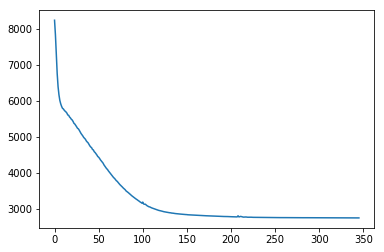

In [203]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(l)

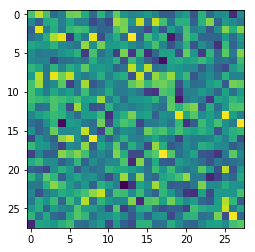

In [205]:
plt.imshow(Fk(Q(Tensor(X_train[15].astype(int))))[3].detach().reshape(28, 28))

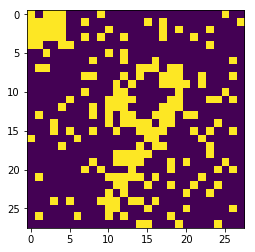

In [161]:
plt.imshow(X_train[423][3].reshape(28, 28))

In [104]:
X_train.shape

(60000, 5, 784)